In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import nltk
import contractions
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import sklearn_crfsuite
from sklearn_crfsuite import metrics

from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from prettytable import PrettyTable
from collections import Counter

In [2]:
reviews = pd.read_json('yelp_reviews.json', lines=True)
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


In [3]:
reviews = reviews[reviews['funny']==0]

In [4]:
reviews['text_length'] = reviews.text.map(len)

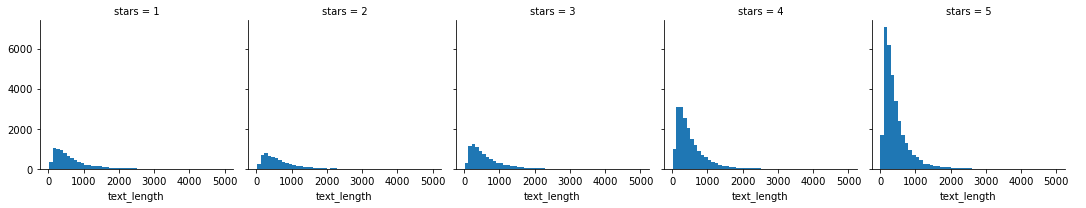

In [5]:
#is there a trend with review length and number of stars given?
graph = sns.FacetGrid(reviews, col ="stars").map(plt.hist, "text_length", bins=50).add_legend();

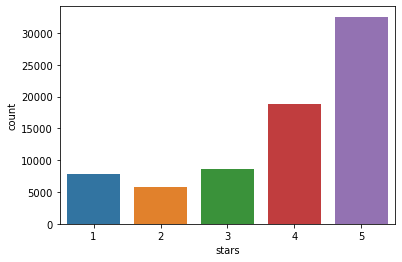

In [6]:
sns.countplot(x ='stars', data = reviews);

In [7]:
yelp_df = reviews[['text', 'stars']].copy()
yelp_df.head()

,text,stars
1,This store is pretty good. Not as great as Wal...,4
2,I called WVM on the recommendation of a couple...,5
4,The food is always great here. The service fro...,4
5,"This place used to be a cool, chill place. Now...",1
6,"The setting is perfectly adequate, and the foo...",2


In [8]:
#check for missing data
yelp_df.isna().sum()

text     0
stars    0
dtype: int64

In [9]:
yelp_df.dtypes

text     object
stars     int64
dtype: object

In [10]:
len(reviews)

73640

In [11]:
yelp_df['stars'].unique()

array([4, 5, 1, 2, 3])

In [12]:
lemmatizer = WordNetLemmatizer()
def clean(text, stopwords):
    # remove tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text) 
    # split text on whitespace
    text_list = text.split()
    expanded_words = []
    text_words = []
    
    punctuation = set(string.punctuation)
    punctuation.add("“")
    punctuation.add("”")
    
    # keep #tags and @mentions
    ## punctuation.remove("#")
    ## punctuation.remove("@")
    
    #expand contractions
    for word in text_list:
        expanded_words.append(contractions.fix(word))
    
    for word in expanded_words:
        # remove punctuation marks at the beginning
        # of each word
        while len(word) > 0 and word[0] in punctuation:
            word = word[1:]
        # remove punctuation marks at the end of each word
        while len(word) > 0 and word[-1] in punctuation: 
            word = word[:-1]
        # a rule to eliminate most urls
        if len(word) > 0 and "/" not in word: 
            # eliminate stopwords
            if word.lower() not in stopwords:
                # append the word to the text_words list
                text_words.append(word.lower())
    
    #lemmatize words
    cleaner_text = ' '.join([lemmatizer.lemmatize(w) for w in text_words])
    
    return cleaner_text

In [13]:
sw = set(stopwords.words("english"))
#check cleaning
print('Before Cleaning \n')
print(yelp_df.iloc[888]['text'])
print('\n After Cleaning \n')
print(clean(yelp_df.iloc[888]['text'], sw))


Before Cleaning 

Checked in about 11pm. I had room on first floor my other family in 3rd floor. Hair all over my sheets. Everything from long hair to straight hair to pubic hair. I was exhausted. Last thing I wanted to do at midnight was remake a bed. Went to front desk it literally took forever for her to find me "clean" sheets. Went back to room and "clean" sheets then had blood or feces on them. I was so disgusted I should have slept in my car. Instead I took the one clean top sheet and slept on top of that. All the hallways reek of cigarette smoke! The rooms were non smoking yet had ashtrays! The next morning I'm getting dressed and see blood or feces or something smeared on the wall by bathroom! Will never ever stay here again. The night front desk agent was nice but morning front desk was extremely rude! She was standing on her cell phone and completely ignored me until I asked her if she wanted the room keys. Her reply "I guess since you already walked them all the way here" SM

In [14]:
yelp_df['text'] = yelp_df['text'].apply(clean, stopwords=sw) 
yelp_df.head()

,text,stars
1,store pretty good great walmart preferred milf...,4
2,called wvm recommendation couple friend used p...,5
4,food always great service manager well staff s...,4
5,place used cool chill place bunch neanderthal ...,1
6,setting perfectly adequate food come close din...,2


In [15]:
yelp_df.stars.value_counts()

5    32575
4    18798
3     8600
1     7819
2     5848
Name: stars, dtype: int64

In [16]:
yelp_df2 = yelp_df[yelp_df['text'].str.len() > 0] 
yelp_df2.shape

(73640, 2)

In [17]:
X = yelp_df2.text
y = yelp_df2.stars

In [18]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y,stratify=y, test_size=0.10)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full,stratify=y_train_full, test_size=0.18)

In [19]:
models = [MultinomialNB(), KNeighborsClassifier(), RandomForestClassifier(), SGDClassifier()]

tfidf = TfidfVectorizer(min_df=10, max_df=0.5, ngram_range=(1,1), token_pattern='[a-z][a-z][a-z]+')
X_train_tfidf = tfidf.fit_transform(X_train)

x = PrettyTable()

x.field_names = ['model', 'accuracy, Train']

for model in models:
    model.fit(X_train_tfidf, y_train)
    
    acc_train = model.score(X_train_tfidf, y_train)

    x.add_row([model.__class__.__name__, round(acc_train,4)])

print(x)

+------------------------+-----------------+
|         model          | accuracy, Train |
+------------------------+-----------------+
|     MultinomialNB      |      0.6147     |
|  KNeighborsClassifier  |      0.4621     |
| RandomForestClassifier |      0.9998     |
|     SGDClassifier      |      0.662      |
+------------------------+-----------------+


In [20]:
tfidf1 = TfidfVectorizer(min_df=10, max_df=0.5, ngram_range=(1,1), token_pattern='[a-z][a-z][a-z]+')
words_1 = tfidf1.fit_transform(yelp_df2['text'][(yelp_df2['stars']== 1)])
words_1 = words_1.toarray()
words_1 = pd.DataFrame(words_1, columns=tfidf1.get_feature_names())

In [21]:
frequent_words_1 = words_1.sum(axis=0).sort_values(ascending=False)[:10]
frequent_words_1

food       272.231912
service    231.368741
time       220.004364
place      218.489404
would      214.175217
get        188.913006
back       180.425832
one        178.996362
order      178.801579
like       168.822905
dtype: float64

In [22]:
tfidf2 = TfidfVectorizer(min_df=10, max_df=0.5, ngram_range=(1,1), token_pattern='[a-z][a-z][a-z]+')
words_2 = tfidf2.fit_transform(yelp_df2['text'][(yelp_df2['stars']== 2)])
words_2 = words_2.toarray()
words_2 = pd.DataFrame(words_2, columns=tfidf2.get_feature_names())

In [23]:
frequent_words_2 = words_2.sum(axis=0).sort_values(ascending=False)[:10]
frequent_words_2

food       245.824170
good       188.700503
place      182.394674
service    166.331964
time       161.073528
would      153.932276
like       148.930674
get        132.182806
one        130.222238
back       124.882854
dtype: float64

In [24]:
tfidf3 = TfidfVectorizer(min_df=10, max_df=0.5, ngram_range=(1,1), token_pattern='[a-z][a-z][a-z]+')
words_3 = tfidf3.fit_transform(yelp_df2['text'][(yelp_df2['stars']== 3)])
words_3 = words_3.toarray()
words_3 = pd.DataFrame(words_3, columns=tfidf3.get_feature_names())
frequent_words_3 = words_3.sum(axis=0).sort_values(ascending=False)[:10]
frequent_words_3

food       344.162175
place      288.337899
would      232.549851
service    220.042847
like       214.549829
great      213.945623
time       210.936300
get        188.345342
really     180.336641
one        169.573512
dtype: float64

In [25]:
tfidf4 = TfidfVectorizer(min_df=10, max_df=0.5, ngram_range=(1,1), token_pattern='[a-z][a-z][a-z]+')
words_4 = tfidf4.fit_transform(yelp_df2['text'][(yelp_df2['stars']== 4)])
words_4 = words_4.toarray()
words_4 = pd.DataFrame(words_4, columns=tfidf4.get_feature_names())
frequent_words_4 = words_4.sum(axis=0).sort_values(ascending=False)[:10]
frequent_words_4

good       768.885339
great      675.085512
food       662.913559
place      627.414418
not        552.095838
service    449.407091
time       428.297015
really     396.507606
would      393.737261
like       383.069489
dtype: float64

In [26]:
tfidf5 = TfidfVectorizer(min_df=10, max_df=0.5, ngram_range=(1,1), token_pattern='[a-z][a-z][a-z]+')
words_5 = tfidf5.fit_transform(yelp_df2['text'][(yelp_df2['stars']== 5)])
words_5 = words_5.toarray()
words_5 = pd.DataFrame(words_5, columns=tfidf5.get_feature_names())
frequent_words_5 = words_5.sum(axis=0).sort_values(ascending=False)[:10]
frequent_words_5

great      1246.121540
food       1070.769241
place      1048.648150
good        865.692581
service     819.801699
not         807.509293
time        718.236339
best        683.179895
love        664.826061
amazing     621.117930
dtype: float64

In [27]:
reviews_pipe = Pipeline([("tfidf",tfidf), 
                        ("clf", RandomForestClassifier())])

reviews_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, min_df=10,
                                 token_pattern='[a-z][a-z][a-z]+')),
                ('clf', RandomForestClassifier())])

In [28]:
reviews_pipe.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(max_df=0.5, min_df=10, token_pattern='[a-z][a-z][a-z]+')),
  ('clf', RandomForestClassifier())],
 'verbose': False,
 'tfidf': TfidfVectorizer(max_df=0.5, min_df=10, token_pattern='[a-z][a-z][a-z]+'),
 'clf': RandomForestClassifier(),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 0.5,
 'tfidf__max_features': None,
 'tfidf__min_df': 10,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '[a-z][a-z][a-z]+',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'clf__bootstrap': True,
 'clf__ccp_alpha': 0.0,
 'clf__class_weight': None,
 'clf__criterion': 'gini',
 

In [32]:
max_depth=[128, 256, 512]
n_estimators = [64, 128, 256]

param_grid_reviews = [{'clf__max_depth': max_depth,
                       'clf__n_estimators': n_estimators,
                       'tfidf__min_df':[1, 10],
                       'tfidf__ngram_range':[(1,1), (1, 2), (1,3)]}]

grid_reviews = GridSearchCV(estimator=reviews_pipe, param_grid =param_grid_reviews, cv=3) 

grid_reviews.fit(X_valid, y_valid)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.5, min_df=10,
                                                        token_pattern='[a-z][a-z][a-z]+')),
                                       ('clf', RandomForestClassifier())]),
             param_grid=[{'clf__max_depth': [128, 256, 512],
                          'clf__n_estimators': [64, 128, 256],
                          'tfidf__min_df': [1, 10],
                          'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]}])

In [33]:
best = grid_reviews.best_estimator_
best.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(max_df=0.5, min_df=10, ngram_range=(1, 2),
                   token_pattern='[a-z][a-z][a-z]+')),
  ('clf', RandomForestClassifier(max_depth=128, n_estimators=128))],
 'verbose': False,
 'tfidf': TfidfVectorizer(max_df=0.5, min_df=10, ngram_range=(1, 2),
                 token_pattern='[a-z][a-z][a-z]+'),
 'clf': RandomForestClassifier(max_depth=128, n_estimators=128),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 0.5,
 'tfidf__max_features': None,
 'tfidf__min_df': 10,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '[a-z][a-z][a-z]+',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': T

In [34]:
print(f'Best Estimator Training accuracy: {best.score(X_train, y_train):.4f}')
print(f'Best Estimator Test accuracy: {best.score(X_test, y_test):.4f}')

Best Estimator Training accuracy: 0.5530
Best Estimator Test accuracy: 0.5477
